# Exploratory/Descriptive Analysis

Vamos neste notebook gerar análises descritivas dos dados disponibilizados pelo Spotify no RecSys Challenge 2018, assim como nas características obtidas por meio da API do Spotify.

<br><br>
<hr>
@author: [Pedro Correia](https://github.com/pfcor)

In [1]:
# file paths
PLAYLISTS_FILE        = "data/formatted/playlists.fthr"
TRACKS_FILE           = "data/formatted/tracks.fthr"
TRACKS_METADATA_FILE  = "data/metadata/tracks_metadata.csv"
ARTISTS_FILE          = "data/formatted/artists.fthr"
ARTISTS_METADATA_FILE = "data/metadata/artists_metadata.csv"
PLAYLIST_TRACK_FILE   = "data/formatted/playlist_track.fthr"

In [96]:
# imports

import datetime as dt
import ast
from collections import Counter

import feather
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_style("white")

import mpd

%matplotlib inline

Primeiramente, vamos buscar obter números gerais de nosso data set.

<b>1_</b><br>
*playlists*

In [111]:
# carregando dados

df_playlists = feather.read_dataframe(PLAYLISTS_FILE)

In [112]:
# tratamento da variável nome

df_playlists.fillna({"name": "noname"}, inplace=True)
df_playlists["name"] = df_playlists["name"].apply(mpd.normalize_name)

In [113]:
# acrescentando uma variavel

df_playlists["artist_diversity"] = df_playlists["num_artists"] / df_playlists["num_tracks"]

In [117]:
# timestamp modified_dt

df_playlists["modified_at"] = df_playlists["modified_at"].apply(lambda x: dt.datetime.strptime(dt.datetime.fromtimestamp(x).strftime("%Y-%m-%d"), "%Y-%m-%d"))

In [160]:
# duração em minutos para mais facil interpretação

df_playlists["duration_min"] = df_playlists["duration_ms"] / (1000 * 60)

In [118]:
df_playlists.sample(10)

,pid,name,collaborative,modified_at,duration_ms,num_tracks,num_albums,num_artists,num_followers,num_edits,artist_diversity
639170,674170,boston,0,2014-10-18,8275667,35,33,32,4,6,0.914286
162566,244566,new,0,2016-09-20,10515184,47,42,29,1,7,0.617021
826604,842604,ex,0,2017-05-09,40913473,179,161,139,1,112,0.776536
165682,247682,old school,0,2015-08-07,36922152,141,109,79,6,22,0.560284
950230,954230,hard rock,0,2017-10-11,15602810,61,43,26,1,9,0.426230
488490,538490,marathon,0,2015-05-29,17996057,76,60,54,1,11,0.710526
188709,268709,new,0,2017-08-06,4183805,19,14,11,1,2,0.578947
287725,357725,90s,0,2017-03-09,20642106,86,68,50,1,9,0.581395
418975,475975,ski,0,2017-05-23,28464724,122,111,93,1,7,0.762295
906258,914258,photograph,0,2017-04-17,2762408,13,8,7,1,6,0.538462


In [119]:
n_playlists = df_playlists.shape[0]
print(f"São {n_playlists//1e6:.0f}M playlists diferentes presentes na base")

São 1M playlists diferentes presentes na base


a_<br>
`name`

> para este trabalho, não é certo que nos utilizaremos dos nomes das playlists em nosso sistema de recomendação, por simplicidade, provavelmente nos circunscrevendo à análise das faixas especificamente. mas em um projeto mais aprofundado, esta certamente seria uma importante fonte de dados. por exemplo, é certo que uma playlist chamada "party" (festa), certamente indica que algumas faixas específicas fazem mais sentido que em uma chamada "chill" (relaxar). assim, vamos observar essa variável de qualquer forma:

In [120]:
# name

n_unique_names = df_playlists["name"].nunique()
names_value_counts    = df_playlists["name"].value_counts()

In [121]:
print(f"São {n_unique_names} diferentes nomes dados para as playlists na base")

São 17127 diferentes nomes dados para as playlists na base


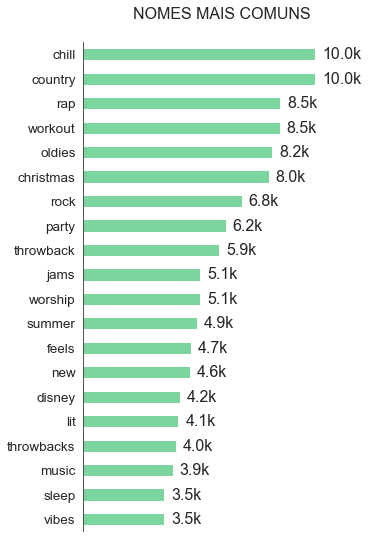

In [122]:
top20 = names_value_counts[:20].sort_values()
max_name = top20.max()

# define figure
fig, ax = plt.subplots(figsize=(5, 9))

# main plot call
top20.plot(ax=ax, kind="barh", color="#7cd59f")
sns.despine(ax=ax, bottom=True)

# title
ax.set_title("NOMES MAIS COMUNS\n", size=16)

# x-axis
ax.set_xticklabels("")
ax.set_xlim(0, max_name*1.2)

# y-axis
plt.yticks(fontsize=13.5)

# val labels
for i, v in enumerate(top20.values):
    ax.text(v + (max_name*0.03), i, f"{v/1000:.1f}k", va="center", size=16)

fig.savefig("plots/names-most-common.png", bbox_inches="tight")

Já vemos que o próprio título da playlist pode ser um indicativo importante dos conteúdos que podem fazer sentido para aquela lista. Em especial, aquelas cujo nome é um estilo musical específico ("country", "rap" ou "rock"). Outras são mais genéricas, como "jams", "vibes" ou "music".

Assim, vamos tentar entender também o quanto da nossa base é representada por nomes que se repetem - e portanto poderiam ser úteis ao nosso sistema de recomendação. 

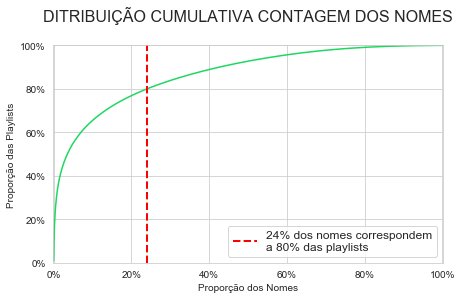

In [123]:
cumsum_names = (names_value_counts/names_value_counts.sum()).cumsum()
pct_names_80 = ((cumsum_names <= 0.8).sum() / len(cumsum_names))
# cumsum_names = (names_value_counts/1).cumsum()

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(7,4))

ax.plot(
    (np.array(range(len(cumsum_names)))/len(cumsum_names)), 
    cumsum_names.values, 
    color="#1ed760"
)
ax.axvline(
    pct_names_80, 
    ls="--", 
    lw=2, 
    color="r", 
    label=f"{pct_names_80:.0%} dos nomes correspondem\na 80% das playlists"
)

# title
ax.set_title("DITRIBUIÇÃO CUMULATIVA CONTAGEM DOS NOMES\n", size=16)

# axis
ax.set_ylim(0,1)
ax.set_yticklabels([f"{x:.0%}" for x in np.arange(0, 1.1, 0.2)])
ax.set_ylabel("Proporção das Playlists")

ax.set_xlim(-0.0025,1.0025)
ax.set_xticklabels([f"{x:.0%}" for x in np.arange(-0.2, 1.1, 0.2)])
ax.set_xlabel("Proporção dos Nomes")

ax.legend(loc="best", prop={'size': 12})

fig.savefig("plots/names-cumsum-distribution.png", bbox_inches="tight")

Vemos que de fato há uma concetração nos nomes mais comuns, mas há ainda uma grande quantidade de playlists cujo nome é, pelo menos em uma primeira análise, que vai primar mais pela repetição de padrões do que pelo significado específico de cada título.



In [124]:
df_artists_metadata = pd.read_csv(ARTISTS_METADATA_FILE, sep=";").drop("Unnamed: 0", axis=1)

In [125]:
%%time
genres_counter = Counter()
for genres in df_artists_metadata["genres"]:
    genres_counter.update(ast.literal_eval(genres))

Wall time: 3.35 s


Antecipando uma análise que ainda vamos fazer sobre os gêneros musicais presentes na base, vamos conferir quantos dos nomes das playlists são, de fato, gêneros musicais:

In [126]:
playlists_are_genres = df_playlists["name"].isin(genres_counter.keys()).mean()
top100_playlists_are_genres = df_playlists.loc[df_playlists["name"].isin(names_value_counts[:100].index), "name"].isin(genres_counter.keys()).mean()
top100_playlist_names_are_genres = df_playlists.loc[df_playlists["name"].isin(names_value_counts[:100].index), "name"].drop_duplicates().isin(genres_counter.keys()).mean()

In [127]:
print(f"no total, {playlists_are_genres:.0%} das playlists tem nome de gênero musical. {top100_playlist_names_are_genres:.0%} dos 100 nomes mais comuns são gêneros musicais, correnspondendo a {top100_playlists_are_genres:.0%} das playlists com nomes entre esses mais comuns")

no total, 11% das playlists tem nome de gênero musical. 18% dos 100 nomes mais comuns são gêneros musicais, correnspondendo a 25% das playlists com nomes entre esses mais comuns


In [128]:
# exemplos
for pl in df_playlists.loc[df_playlists["name"].isin(genres_counter.keys()), "name"].drop_duplicates().sample(10).values:
    print(pl)

sleep
ccm
vallenato
tekno
punjabi
banjo
afrobeats
jazz funk
melbourne bounce
bounce


In [129]:
# limpando namespace
del df_artists_metadata

Vamos rapidamente fazer a mesma análise com nomes de artistas:

In [130]:
df_artists = feather.read_dataframe(ARTISTS_FILE)

In [131]:
artists = df_artists["artist_name"].fillna("unknown").apply(mpd.normalize_name).values

In [132]:
playlists_are_artists = df_playlists["name"].isin(artists).mean()

In [133]:
print(f"com bem maior prevalência, são cerca de {playlists_are_artists:.0%} as playlists na base com nomes de artistas")

com bem maior prevalência, são cerca de 41% as playlists na base com nomes de artistas


Na sequência, caberia verificar que as playlists com nomes de determinado artista realmente tem apenas faixas desse artista, ou se ainda seria melhor garantir variabilidade nas recomendações.

In [134]:
# exemplos
for pl in df_playlists.loc[df_playlists["name"].isin(artists), "name"].drop_duplicates().sample(20).values:
    print(pl)

astrid
bruna
shut up and dance
to
karina
gg
a ap mob
macklemore & ryan lewis
state of mind
neon trees
abigail
pity party
drive
la oreja de van gogh
sufjan stevens
gs
musica disco
all sons & daughters
jump
snow patrol


Alguns nomes curiosos que potencialmente nem são de fato referenciando artistas (e.g. "gg"). Cabe maior análise para uso no sistema de recomendação.

Claramente há enorme potencial para seguir investigando esta variável e criar diferentes estratégias de como absorvê-la no sistema de recomendação. Mas vamos, para agora, buscar observar as outras informações disponíveis no conjunto de dados.

In [139]:
# limpando namespace
del df_artists

b_<br>
`collaborative`

> indica simplesmente se a playlist em questão pode ser editada por outro usuário além do criador. muito provavelmente não terá utilização no sistema de recomendação final.

In [140]:
pct_collab = df_playlists['collaborative'].mean()

In [141]:
print(f"{pct_collab:.1%} das playlists são colaborativas") # tabela de frequencia

2.3% das playlists são colaborativas


In [142]:
df_playlists.groupby("collaborative")[["num_tracks", "num_edits", "artist_diversity"]].median()

,num_tracks,num_edits,artist_diversity
collaborative,,,
0,49,10,0.666667
1,59,13,0.722772


Playlists colaborativas aparentemente são um pouco mais longas, e sofrem mais alterações, o que faz bastante sentido. Além disso, tendem a ser um pouco mais diversas, apesar de que em geral mais faixas tendem a reduzir a diversidade.

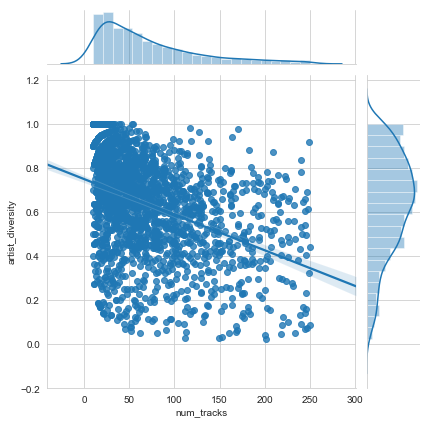

In [144]:
sns.jointplot(x="num_tracks", y="artist_diversity", data=df_playlists[df_playlists["num_tracks"] >= 10].sample(frac=0.002), kind="reg")

c_<br>
`modified_at`
> última data de modificação da playlist, também muito provavelmente não será usada

In [148]:
df_playlists["modified_at"].describe()

count                 1000000
unique                   2294
top       2017-10-30 00:00:00
freq                    19018
first     2010-04-15 00:00:00
last      2017-10-31 00:00:00
Name: modified_at, dtype: object

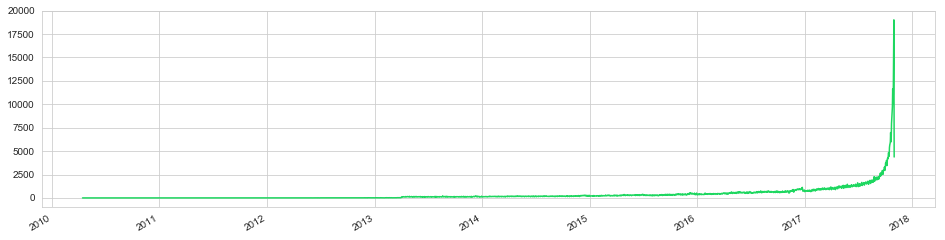

In [193]:
df_playlists["modified_at"].value_counts().sort_index().plot(figsize=(16,4), color="#1ed760")

Vemos que há um aumento explosivo na segunda metade de 2017 em relação às observações de últimas edições. Isso pode estar relacionado à amostragem relaizada pelo Spotify para este data set.

d_<br>
`duration_min` & `num_tracks`

> são medidas de tamanho da playlist e serão tratadas em conjunto para essa análise. o fato é que em nossas experimentações em sistemas de recomendações, esse tipo de variável provavelmente não entra na predição de novos itens.

In [172]:
df_playlists.loc[df_playlists["duration_min"]<1200, "duration_min"].describe()

count    999426.000000
mean        258.990681
std         212.121341
min           1.625633
25%          99.873937
50%         190.247075
75%         356.777271
max        1199.523967
Name: duration_min, dtype: float64

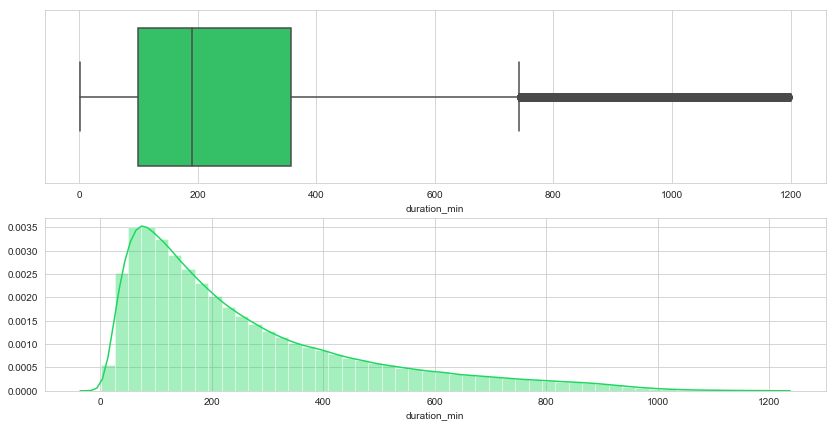

In [204]:
fig, ax = plt.subplots(2,1,figsize=(14,7))
sns.boxplot(df_playlists.loc[df_playlists["duration_min"]<1200, "duration_min"], color="#1ed760", ax=ax[0])
sns.distplot(df_playlists.loc[df_playlists["duration_min"]<1200, "duration_min"], color="#1ed760", ax=ax[1])

In [174]:
df_playlists.loc[df_playlists["num_tracks"]<=250, "num_tracks"].describe()

count    999999.000000
mean         66.346118
std          53.668492
min           5.000000
25%          26.000000
50%          49.000000
75%          92.000000
max         250.000000
Name: num_tracks, dtype: float64

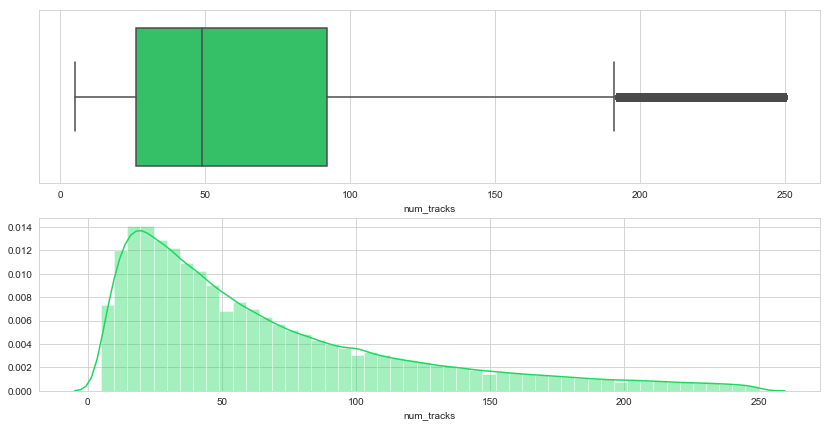

In [205]:
fig, ax = plt.subplots(2,1,figsize=(14,7))
sns.boxplot(df_playlists.loc[df_playlists["num_tracks"]<=250, "num_tracks"], color="#1ed760", ax=ax[0])
sns.distplot(df_playlists.loc[df_playlists["num_tracks"]<=250, "num_tracks"], color="#1ed760", ax=ax[1])

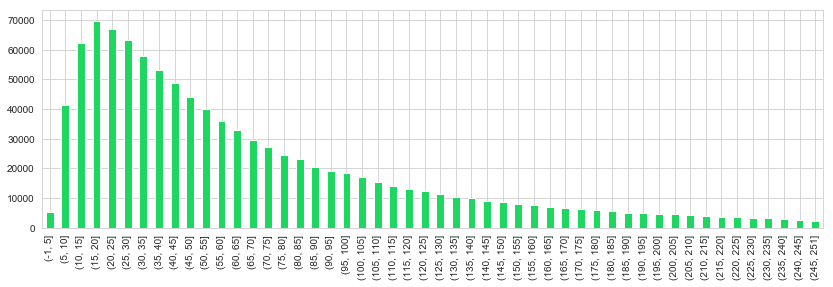

In [199]:
pd.cut(df_playlists["num_tracks"], bins=[-1]+list(range(5, 250, 5))+[251]).value_counts().sort_index().plot.bar(figsize=(14,4), color="#1ed760")

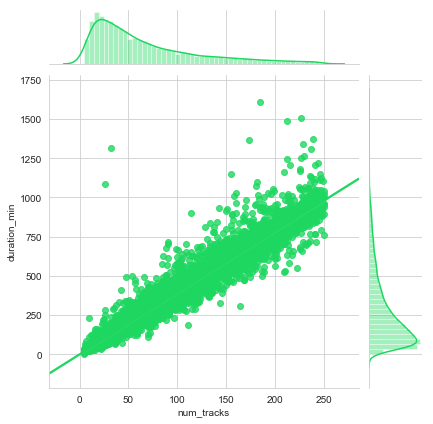

In [201]:
sns.jointplot(x="num_tracks", y="duration_min", data=df_playlists.sample(frac=0.02), kind="reg", color="#1ed760")